In [1]:
%reload_ext autotime
import pandas as pd
import requests
import geopandas as gpd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map
import time
import os
from glob import glob
from coastsat import SDS_transects
import json
import matplotlib.pyplot as plt
import dotenv
dotenv.load_dotenv()

True

In [2]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

area id_sorted      northing  \
id                                              
nzd0001  3.069093e+06   nzd0001 -4.085604e+06   
nzd0002  1.507931e+06   nzd0002 -4.086100e+06   
nzd0003  2.484730e+06   nzd0003 -4.087232e+06   
nzd0006  9.619509e+05   nzd0004 -4.090732e+06   
nzd0007  3.109433e+06   nzd0005 -4.095516e+06   
...               ...       ...           ...   
nzd0314  3.124363e+07   nzd0559 -4.943102e+06   
nzd0561  8.710035e+05   nzd0560 -5.905869e+06   
nzd0562           NaN      None           NaN   
nzd0563           NaN      None           NaN   
nzd0564           NaN      None           NaN   

                                                  geometry  
id                                                          
nzd0001  POLYGON ((172.96406 -34.43054, 172.99324 -34.4...  
nzd0002  POLYGON ((172.93456 -34.42857, 172.95856 -34.4...  
nzd0003  POLYGON ((173.0098 -34.42055, 173.00088 -34.44...  
nzd0006  POLYGON ((173.00532 -34.46694, 173.00612 -34.4...  
nzd0007  POLYGON ((172.99847 -34.48102, 173.00081 -34.5...  
...                                                    ...  
nzd0314  POLYGON ((173.04122 -40.54521, 172.89309 -40.5...  
nzd0561  POLYGON ((168.53017 -46.77383, 168.52 -46.7786...  
nzd0562  POLYGON ((174.90844 -36.8799, 174.90844 -36.86...  
nzd0563  POLYGON ((176.9378 -39.33472, 176.93374 -39.33...  
nzd0564  POLYGON ((173.32212 -41.20147, 173.36513 -41.1...  

[563 rows x 4 columns]

1999-08-17 22:10:00+00:00 POINT (172.97690966086745 -34.42150701355086)


<Axes: xlabel='time'>

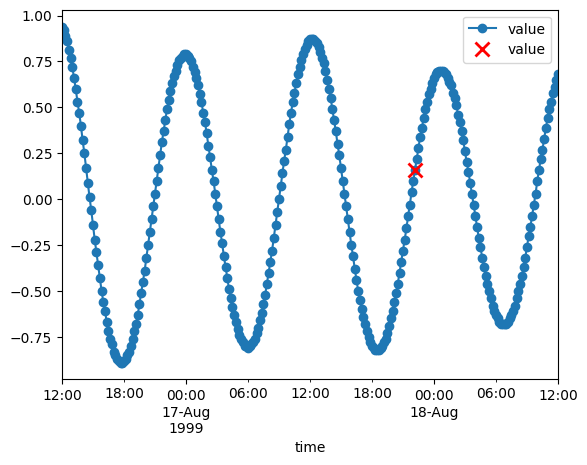

In [3]:
sitename = "nzd0001"
dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
point = poly.geometry[sitename].centroid
datetime = dates.iloc[0]
print(datetime, point)
r = requests.get("https://api.niwa.co.nz/tides/data", params={
    "lat": point.y,
    "long": point.x,
    "numberOfDays": 2,
    "startDate": str(datetime.date()),
    "datum": "MSL",
    "interval": 10, # 10 minute resolution
    "apikey": os.environ["NIWA_API_KEY"]
}, timeout=(30,30))
df = pd.DataFrame(r.json()["values"])
df.index = pd.to_datetime(df.time)
ax = df.plot(style="o-")
df[df.index == datetime].plot(color="red", style="x", ax=ax, mew=2, ms=10)

In [4]:
datetime, datetime.tz_convert("Pacific/Auckland")

(Timestamp('1999-08-17 22:10:00+0000', tz='UTC'),
 Timestamp('1999-08-18 10:10:00+1200', tz='Pacific/Auckland'))

When I asked for 1 day (1999-08-17), I got 1999-08-16 12:00 - 1999-08-17 12:00. Have to request 2 days, then pull out the one datetime I want

In [5]:
files = pd.DataFrame({"filename": sorted(glob("data/nzd*/transect_time_series.csv"))})
files["sitename"] = files.filename.str.split("/").str[1]
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))
files

filename sitename  have_tides
0    data/nzd0001/transect_time_series.csv  nzd0001        True
1    data/nzd0002/transect_time_series.csv  nzd0002        True
2    data/nzd0003/transect_time_series.csv  nzd0003        True
3    data/nzd0004/transect_time_series.csv  nzd0004        True
4    data/nzd0005/transect_time_series.csv  nzd0005        True
..                                     ...      ...         ...
558  data/nzd0560/transect_time_series.csv  nzd0560        True
559  data/nzd0561/transect_time_series.csv  nzd0561        True
560  data/nzd0562/transect_time_series.csv  nzd0562        True
561  data/nzd0563/transect_time_series.csv  nzd0563        True
562  data/nzd0564/transect_time_series.csv  nzd0564       False

[563 rows x 3 columns]

In [6]:
def get_tide_for_dt(point, datetime):
    while True:
        try:
            r = requests.get("https://api.niwa.co.nz/tides/data", params={
                "lat": point.y,
                "long": point.x,
                "numberOfDays": 2,
                "startDate": str(datetime.date()),
                "datum": "MSL",
                "interval": 10, # 10 minute resolution
                "apikey": os.environ["NIWA_API_KEY"]
            }, timeout=(30,30))
        except Exception as e:
            print(e)
            time.sleep(5)
            continue
        if r.status_code == 200:
            df = pd.DataFrame(r.json()["values"])
            df.index = pd.to_datetime(df.time)
            return df.value[datetime]
        elif r.status_code == 429:
            sleep_seconds = 30
            # sleep for x seconds to refresh the count
            print(f'Num of API reqs exceeded, Sleeping for: {sleep_seconds} seconds...')
            time.sleep(sleep_seconds)

for sitename in tqdm(files[~files.have_tides].sitename):
    dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
    point = poly.geometry[sitename].centroid

    results = []
    for date in tqdm(dates):
        result = get_tide_for_dt(point, date)
        results.append({
            "dates": date,
            "tide": result
        })
    df = pd.DataFrame(results)
    df.set_index("dates", inplace=True)
    df.to_csv(f"data/{sitename}/tides.csv")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/994 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...


Num of API reqs exceeded, Sleeping for: 30 seconds...


In [7]:
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))

In [8]:
# Transects, origin is landward. Has beach_slope
transects = gpd.read_file("transects_extended.geojson").to_crs(2193).drop_duplicates(subset="id")
transects.set_index("id", inplace=True)
transects

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
aus0001-0000  aus0001   104.347648    0.000000         0.000000        0.085   
aus0001-0001  aus0001    93.495734   98.408334         0.002935        0.050   
aus0001-0002  aus0001    82.069341  198.408334         0.005918        0.050   
aus0001-0003  aus0001    81.192757  298.402523         0.008900        0.055   
aus0001-0004  aus0001    81.065473  398.402523         0.011882        0.075   
...               ...          ...         ...              ...          ...   
nzd0564-0046  nzd0564          NaN         NaN              NaN          NaN   
nzd0564-0047  nzd0564          NaN         NaN              NaN          NaN   
nzd0564-0048  nzd0564          NaN         NaN              NaN          NaN   
nzd0564-0049  nzd0564          NaN         NaN              NaN          NaN   
nzd0564-0050  nzd0564          NaN         NaN              NaN          NaN   

                 cil     ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                           
aus0001-0000  0.0545  0.2000 -1.441081     767.0           428.0  0.168420   
aus0001-0001  0.0387  0.0640 -1.037105     767.0           569.0  0.097874   
aus0001-0002  0.0428  0.0647 -0.680019     767.0           588.0  0.053927   
aus0001-0003  0.0480  0.0659 -0.405198     767.0           598.0  0.023412   
aus0001-0004  0.0614  0.0922 -0.090025     767.0           608.0  0.001277   
...              ...     ...       ...       ...             ...       ...   
nzd0564-0046     NaN     NaN       NaN       NaN             NaN       NaN   
nzd0564-0047     NaN     NaN       NaN       NaN             NaN       NaN   
nzd0564-0048     NaN     NaN       NaN       NaN             NaN       NaN   
nzd0564-0049     NaN     NaN       NaN       NaN             NaN       NaN   
nzd0564-0050     NaN     NaN       NaN       NaN             NaN       NaN   

                    mae          mse       rmse   intercept ERODIBILITY  \
id                                                                        
aus0001-0000  28.102591  1263.560863  35.546601  179.085729        None   
aus0001-0001  25.419324  1033.770813  32.152306  212.247788        None   
aus0001-0002  22.632907   838.007507  28.948359  205.106151        None   
aus0001-0003  20.749758   698.653187  26.432048  191.745881        None   
aus0001-0004  19.889328   655.810616  25.608800  175.092121        None   
...                 ...          ...        ...         ...         ...   
nzd0564-0046        NaN          NaN        NaN         NaN        None   
nzd0564-0047        NaN          NaN        NaN         NaN        None   
nzd0564-0048        NaN          NaN        NaN         NaN        None   
nzd0564-0049        NaN          NaN        NaN         NaN        None   
nzd0564-0050        NaN          NaN        NaN         NaN        None   

                                                       geometry  
id                                                               
aus0001-0000  LINESTRING (-422245.836 7118667.88, -421827.54...  
aus0001-0001  LINESTRING (-422256.313 7118525.222, -421837.6...  
aus0001-0002  LINESTRING (-422219.773 7118383.012, -421816.8...  
aus0001-0003  LINESTRING (-422187.543 7118279.615, -421786.5...  
aus0001-0004  LINESTRING (-422155.665 7118178.983, -421754.9...  
...                                                         ...  
nzd0564-0046  LINESTRING (1630436.415 5440463.658, 1630195.7...  
nzd0564-0047  LINESTRING (1630500.321 5440511.784, 1630259.6...  
nzd0564-0048  LINESTRING (1630576.662 5440571.499, 1630309.8...  
nzd0564-0049  LINESTRING (1630636.335 5440624.99, 1630369.27...  
nzd0564-0050  LINESTRING (1630695.905 5440678.389, 1630428.8...  

[147245 rows x 17 columns]

In [9]:
def despike(chainage, threshold=40):
    chainage = chainage.dropna()
    chainage, dates = SDS_transects.identify_outliers(chainage.tolist(), chainage.index.tolist(), threshold)
    return pd.Series(chainage, index=dates)

def process_sitename(sitename):
    transects_at_site = transects[transects.site_id == sitename]
    assert len(transects_at_site)
    raw_intersects = pd.read_csv(f"data/{sitename}/transect_time_series.csv")#.drop(columns=["Unnamed: 0"])
    sat_times = pd.to_datetime(raw_intersects.dates).dt.round("10min")
    raw_intersects.set_index("dates", inplace=True)
    raw_intersects.index = pd.to_datetime(raw_intersects.index)
    tides = pd.read_csv(f"data/{sitename}/tides.csv")
    tides.set_index("dates", inplace=True)
    tides.index = pd.to_datetime(tides.index)
    tides = tides[tides.index.isin(sat_times)]
    if not all(sat_times.isin(tides.index)):
        dates = sat_times[~sat_times.isin(tides.index)]
        print(f"Fetching missing tides for {len(dates)} dates at {sitename}")
        point = poly.geometry[sitename].centroid
        results = []
        for date in tqdm(dates):
            result = get_tide_for_dt(point, date)
            results.append({
                "dates": date,
                "tide": result
            })
        new_tides = pd.DataFrame(results)
        new_tides.dates = pd.to_datetime(new_tides.dates)
        new_tides.set_index("dates", inplace=True)
        tides = pd.concat([tides, new_tides])
        tides.sort_index(inplace=True)
        tides.to_csv(f"data/{sitename}/tides.csv")
    corrections = tides.tide.apply(lambda tide: tide / transects_at_site.beach_slope.interpolate().bfill().ffill()).set_index(raw_intersects.index)
    corrections.columns = corrections.columns.astype(str)
    tidally_corrected = raw_intersects + corrections
    tidally_corrected = tidally_corrected.drop(columns="satname").apply(despike, axis=0)
    tidally_corrected.index.name = "dates"
    if len(tidally_corrected) == 0:
        print(f"Despike removed all points for {sitename}")
    tidally_corrected["satname"] = raw_intersects.satname
    tidally_corrected.to_csv(f"data/{sitename}/transect_time_series_tidally_corrected.csv")
    return tidally_corrected

_ = process_map(process_sitename, files.sitename)
#process_sitename("nzd0562")

  0%|          | 0/563 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0011

Fetching missing tides for 1 dates at nzd0004

Fetching missing tides for 1 dates at nzd0007

Fetching missing tides for 1 dates at nzd0003

Fetching missing tides for 1 dates at nzd0015

Fetching missing tides for 1 dates at nzd0019

Fetching missing tides for 1 dates at nzd0026

Fetching missing tides for 2 dates at nzd0024

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0032

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0027

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0034

*

Fetching missing tides for 2 dates at nzd0035

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0036

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0037

Fetching missing tides for 2 dates at nzd0038

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0043

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0047

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0048

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0050

*

Fetching missing tides for 1 dates at nzd0049

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0051

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0052

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0053

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0058

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0062

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0064

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0065

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0067

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0068

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0069

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0071

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0072

Fetching missing tides for 2 dates at nzd0073

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0074

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0076

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0079

*

Fetching missing tides for 1 dates at nzd0078

Fetching missing tides for 1 dates at nzd0080

Fetching missing tides for 1 dates at nzd0077

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0081

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0082

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0086

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0087

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0091

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0093

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0098

Fetching missing tides for 1 dates at nzd0099

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0100

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0102

Fetching missing tides for 2 dates at nzd0103

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 1 dates at nzd0105

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0109

Fetching missing tides for 1 dates at nzd0111

*

*

Fetching missing tides for 2 dates at nzd0110

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0123

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0124

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0125

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0130

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0131

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0133

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0134

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0135

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 1 dates at nzd0137

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 1 dates at nzd0138

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0141

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0143

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0144

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0146

Fetching missing tides for 2 dates at nzd0148

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0149

Fetching missing tides for 1 dates at nzd0151

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0155

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0167

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0169

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0171

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0174

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0178

Fetching missing tides for 1 dates at nzd0179

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0182

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0183

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0184

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0185

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0186

*

Fetching missing tides for 1 dates at nzd0187

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0188

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0189

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0190

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0191

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0192

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0193

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0194

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0195

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0196

Fetching missing tides for 1 dates at nzd0197

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0198

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0199

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0200

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0201

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0202

*

Fetching missing tides for 1 dates at nzd0203

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0204

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0205

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0206

*

Fetching missing tides for 2 dates at nzd0207

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0208

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0209

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0211

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0212

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0213

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0214

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0215

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0217

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0218

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0219

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0224

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0225

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0228

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0230

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0223

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0232

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0233

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0235

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0241

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0242

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0243

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0244

*

*

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0245

*

*

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0246

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0247

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0248

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0249

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0250

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0251

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0252

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0253

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0255

Fetching missing tides for 1 dates at nzd0256

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0257

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0258

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0259

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0260

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0261

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0262

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0263

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0264

Fetching missing tides for 1 dates at nzd0265

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0266

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0267

*

Fetching missing tides for 1 dates at nzd0268

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0269

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0270

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0271

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0272

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0273

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0274

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0275

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0276

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0277

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0279

Fetching missing tides for 1 dates at nzd0278

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0280

*

*

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0281

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0282

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0283

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0284

*

Fetching missing tides for 1 dates at nzd0286

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0287

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0289

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0290

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0292

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0296

Fetching missing tides for 1 dates at nzd0295

*

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0298

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0301

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0302

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0303

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0304

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0305

*

*

Fetching missing tides for 1 dates at nzd0306

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0308

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0309

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0310

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0311

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0312

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 1 dates at nzd0315

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0317

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0318

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0319

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0320

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0321

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0322

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0323

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0324

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0325

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0326

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0327

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0328

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0329

*

Fetching missing tides for 1 dates at nzd0330

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0331

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0332

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0333

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0334

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0335

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 2 dates at nzd0336

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0337

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0338

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0339

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0340

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 1 dates at nzd0341

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0342

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0343

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0344

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0345

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0346

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0350

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0351

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0352

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0353

Fetching missing tides for 1 dates at nzd0354

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0355

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0356

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0357

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0361

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0364

Fetching missing tides for 1 dates at nzd0362

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0366

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 3 dates at nzd0367

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0368

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0369

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0370

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0371

Fetching missing tides for 2 dates at nzd0372

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0374

Fetching missing tides for 1 dates at nzd0375

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0376

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0377

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0384

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0386

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0387

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0389

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0390

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0391

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0393

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0394

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0395

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0396

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0397

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0399

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0401

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0402

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0403

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0405

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0406

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0407

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0408

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0410

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0411

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0412

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0415

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0416

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0417

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0420

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0421

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0422

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0423

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0425

*

Fetching missing tides for 2 dates at nzd0424

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0430

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0431

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0432

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0433

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0435

Fetching missing tides for 2 dates at nzd0434

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0436

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0437

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0439

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0440

Fetching missing tides for 1 dates at nzd0441

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0442

*

Fetching missing tides for 1 dates at nzd0443

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0444

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0445

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0446

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0447

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0448

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0449

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0450

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0452

*

*

*

Fetching missing tides for 1 dates at nzd0451

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0453

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0454

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0455

Fetching missing tides for 2 dates at nzd0456

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0457

*

*

Fetching missing tides for 2 dates at nzd0458

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0459

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0477

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0479

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0480

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0481

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0482

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0493

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0500

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0502

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0509

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0510

*

Fetching missing tides for 1 dates at nzd0511

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0514

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0515

*

Fetching missing tides for 1 dates at nzd0516

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0517

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0518

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0519

*

*

Fetching missing tides for 1 dates at nzd0520

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0521

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0522

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0523

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0524

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0525

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0526

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0527

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0528

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0529

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0530

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0531

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 3 dates at nzd0532

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0533

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0534

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0535

*

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0536

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0537

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0538

Fetching missing tides for 1 dates at nzd0539

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0540

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0541

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0542

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0543

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0544

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0545

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0546

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0547

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0548

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 1 dates at nzd0549

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0550

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0551

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0552

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0553

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0554

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0557

  0%|          | 0/2 [00:00<?, ?it/s]

Despike removed all points for nzd0555

*

Fetching missing tides for 2 dates at nzd0558

*

Fetching missing tides for 2 dates at nzd0559

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0560

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0561

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0562

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Despike removed all points for nzd0564

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*